In [1]:
import VariationalBayes.Parameters as par
from VariationalBayes.ParameterDictionary import ModelParamsDict

from VariationalBayes.MultinomialParams import SimplexParam

import math

import autograd
import autograd.numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import time

#import copy
from copy import deepcopy
import scipy as sp
from scipy.sparse.linalg import LinearOperator
from scipy import optimize
from scipy import stats

In [21]:
# Number of data points:
n_num = 100

# Dimension of observations:
d_num = 2

# Number of clusters:
k_num = 2

mu_scale = 3
noise_scale = 0.5

true_pi = np.linspace(0.2, 0.8, k_num)
true_pi = true_pi / np.sum(true_pi)

true_z = np.random.multinomial(1, true_pi, n_num)
true_z_ind = np.full(n_num, -1)
for row in np.argwhere(true_z):
    true_z_ind[row[0]] = row[1]

mu_prior_mean = np.full(d_num, 0.)
mu_prior_cov = np.diag(np.full(d_num, mu_scale ** 2))
mu_prior_info = np.linalg.inv(mu_prior_cov)
true_mu = np.random.multivariate_normal(mu_prior_mean, mu_prior_cov, k_num)

true_sigma = np.array([ np.diag(np.full(d_num, noise_scale ** 2)) + np.full((d_num, d_num), 0.1) \
                        for k in range(k_num) ])
true_info = np.array([ np.linalg.inv(true_sigma[k, :, :]) for k in range(k_num) ])

x = np.array([ np.random.multivariate_normal(true_mu[true_z_ind[n]], true_sigma[true_z_ind[n]]) \
               for n in range(n_num) ])


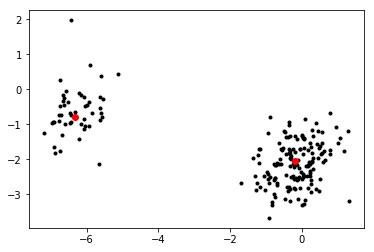

In [3]:
# Never a bad idea to visualize the dataz
plt.plot(x[:,0], x[:,1], 'k.')
for k in range(k_num):
    plt.plot(true_mu[k, 0], true_mu[k, 1], 'ro')

In [22]:
global_params = ModelParamsDict('global')

global_params.push_param(
    par.PosDefMatrixParamVector(name='info', length=k_num, matrix_size=d_num))
global_params.push_param(
    par.ArrayParam(name='mu', shape=(k_num, d_num)))
global_params.push_param(
    SimplexParam(name='pi', shape=(1, k_num)))

local_params = \
    SimplexParam(name='e_z', shape=(n_num, k_num),
                 val=np.full(true_z.shape, 1. / k_num))

single_local_params = \
    SimplexParam(name='e_z', shape=(1, k_num), val=np.full((1, k_num), 1. / k_num))

params = ModelParamsDict('mixture model')
params.push_param(global_params)
params.push_param(local_params)

true_init = False
if true_init:
    params['global']['info'].set(true_info)
    params['global']['mu'].set(true_mu)
    params['global']['pi'].set(true_pi)
else:
    params['global']['mu'].set(np.random.random(params['global']['mu'].shape()))
    

single_obs_params = ModelParamsDict('mixture model single obs')
single_obs_params.push_param(params['global'])
single_obs_params.push_param(single_local_params)

init_par_vec = params.get_free()

print(params['global'])

global:
	info:
[[[ 1.  0.]
  [ 0.  1.]]

 [[ 1.  0.]
  [ 0.  1.]]]
	mu:
[[ 0.67949813  0.52314801]
 [ 0.83010084  0.88803577]]
	pi: [[ 0.5  0.5]]


In [23]:
prior_params = ModelParamsDict()
prior_params.push_param(par.VectorParam(name='mu_prior_mean', size=d_num, val=mu_prior_mean))
prior_params.push_param(par.PosDefMatrixParam(name='mu_prior_info', size=d_num, val=mu_prior_info))
prior_params.push_param(par.ScalarParam(name='alpha', val=2.0))
prior_params.push_param(par.ScalarParam(name='dof', val=d_num + 2.0))

In [24]:
def data_log_likelihood(mu, info, e_z, x, weights):
    k_num = e_z.shape[1]
    assert k_num == mu.shape[0]
    assert k_num == info.shape[0]
    log_lik = 0.0
    # I would be interested to see how this could work without a loop.
    e_z_weighted = weights * e_z
    for k in range(k_num):
        x_centered = x - np.expand_dims(mu[k, :], axis=0)
        log_lik = log_lik - \
            0.5 * np.einsum('ni, ij, nj, n', \
                            x_centered, info[k, :, :], x_centered, e_z_weighted[:, k])
        sign, logdet = np.linalg.slogdet(info[k, :, :])
        assert sign > 0
        log_lik = log_lik + 0.5 * logdet * np.sum(e_z_weighted[:, k])
    return log_lik

def indicator_log_likelihood(e_z, pi):
    return np.sum(np.matmul(e_z, np.log(pi.T)))

def mu_prior(mu, mu_prior_mean, mu_prior_info):
    k_num = mu.shape[0]
    d_num = len(mu_prior_mean)
    assert mu.shape[1] == d_num
    assert mu_prior_info.shape[0] == d_num
    assert mu_prior_info.shape[1] == d_num
    mu_prior_val = 0.0
    for k in range(k_num):
        mu_centered = mu[k, :] - mu_prior_mean
        mu_prior_val += -0.5 * np.matmul(np.matmul(mu_centered, mu_prior_info), mu_centered)
    return mu_prior_val
    
def pi_prior(pi, alpha):
    return np.sum(alpha * np.log(pi))

def info_prior(info, dof):
    k_num = info.shape[0]
    d_num = info.shape[1]
    assert d_num == info.shape[2]
    assert dof > d_num - 1
    # Not a complete Wishart prior
    # TODO: cache the log determinants.
    info_prior_val = 0.0
    for k in range(k_num):
        sign, logdet = np.linalg.slogdet(info[k, :, :])
        info_prior_val += 0.5 * (dof - d_num - 1) * logdet
    return info_prior_val

def multinoulli_entropy(e_z):
    return -1 * np.sum(e_z * np.log(e_z))
    
weights = np.full((n_num, 1), 1.0)
e_z = params['e_z'].get()
data_log_likelihood(true_mu, true_info, e_z, x, weights)
indicator_log_likelihood(e_z, true_pi)
mu_prior(true_mu, mu_prior_mean, mu_prior_info)
pi_prior(true_pi, 2.0)
info_prior(true_info, d_num + 2)
multinoulli_entropy(e_z)

69.314718055994518

In [25]:
class Objective(object):
    def __init__(self, x, params, prior_params):
        self.x = x
        self.params = deepcopy(params)
        self.prior_params = deepcopy(prior_params)
        self.weights = np.full((x.shape[0], 1), 1.0)

        # Autograd derivatives
        self.kl_grad = autograd.grad(self.kl_wrapper)
        self.kl_hessian = autograd.hessian(self.kl_wrapper)
        self.kl_hvp = autograd.hessian_vector_product(self.kl_wrapper)

        self.global_kl_grad = autograd.grad(self.global_kl_wrapper)
        self.global_kl_hvp = autograd.hessian_vector_product(self.global_kl_wrapper)
        self.global_kl_hessian = autograd.hessian(self.global_kl_wrapper)

        self.get_z_nat_params = autograd.grad(self.expected_log_likelihood, argnum=0)

        self.get_moment_jacobian = autograd.jacobian(self.get_interesting_moments)
        
    def expected_log_likelihood(self, e_z, mu, info, pi, weights):
        elbo = 0.0

        # Data:
        elbo += data_log_likelihood(mu, info, e_z, self.x, weights)
        elbo += indicator_log_likelihood(e_z, pi)
        
        # Priors:
        mu_prior_mean = self.prior_params['mu_prior_mean'].get()
        mu_prior_info = self.prior_params['mu_prior_info'].get()
        elbo += mu_prior(mu, mu_prior_mean, mu_prior_info)
        elbo += pi_prior(pi, self.prior_params['alpha'].get())
        elbo += info_prior(info, self.prior_params['dof'].get())

        return elbo
    
    def optimize_z(self):
        # Take a CAVI step on Z.
        info = self.params['global']['info'].get()
        mu = self.params['global']['mu'].get()
        pi = self.params['global']['pi'].get()
        e_z = self.params['e_z'].get()

        natural_parameters = obj.get_z_nat_params(e_z, mu, info, pi, self.weights)
        z_logsumexp = np.expand_dims(sp.misc.logsumexp(natural_parameters, 1), axis=1)
        e_z = np.exp(natural_parameters - z_logsumexp)
        self.params['e_z'].set(e_z)
    
    def kl(self, include_local_entropy=True):
        info = self.params['global']['info'].get()
        mu = self.params['global']['mu'].get()
        pi = self.params['global']['pi'].get()
        e_z = self.params['e_z'].get()

        elbo = self.expected_log_likelihood(e_z, mu, info, pi, self.weights)
        
        if include_local_entropy:
            elbo += multinoulli_entropy(e_z)
        
        return -1 * elbo

    def kl_wrapper(self, free_params, verbose=False):
        self.params.set_free(free_params)
        kl = self.kl()
        if verbose:
            print(kl)
        return kl

    def global_kl_wrapper(self, global_free_params, verbose=False):
        self.params['global'].set_free(global_free_params)
        kl = self.kl(include_local_entropy=False)
        if verbose:
            print(kl)
        return kl
    
    def get_interesting_moments(self, free_params):
        self.params.set_free(free_params)
        return self.params['global']['mu'].get_vector()
    


In [26]:
obj = Objective(x, params, prior_params)
free_par = params.get_free()
global_free_par = params['global'].get_free()
obj.kl_wrapper(free_par)

grad = obj.kl_grad(free_par)
hvp = obj.kl_hvp(free_par, grad)

grad = obj.global_kl_grad(global_free_par)
hvp = obj.global_kl_hvp(global_free_par, grad)
#hessian = obj.global_kl_hessian(global_free_par) # Slow

obj.optimize_z()


In [81]:
z_ind = params.free_indices_dict['e_z']
z_free_indices = np.reshape(list(z_ind), params['e_z'].free_shape())

global_ind = params.free_indices_dict['global']
def log_likelihood(free_param):
    params.set_free(free_param)
    mu = params['global']['mu'].get()
    info = params['global']['info'].get()
    e_z = params['e_z'].get()
    x = obj.x
    weights = obj.weights
    return data_log_likelihood(mu, info, e_z, x, weights)

get_ll_hessian = autograd.hessian(log_likelihood)
hess = get_ll_hessian(init_par_vec)
ll = log_likelihood(init_par_vec)


In [79]:
# sparse_hess[np.ix_(global_ind, global_ind)] = hess[np.ix_(global_ind, global_ind)]
# sparse_hess[np.ix_(global_ind, z_ind)] = hess[np.ix_(global_ind, z_ind)]
# sparse_hess[np.ix_(z_ind, global_ind)] = hess[np.ix_(z_ind, global_ind)]
sparse_hess = np.full((params.free_size(), params.free_size()), 0.)


In [105]:

free_par = params.get_free()

def single_row_log_likelihood(local_free_param, row):
    single_obs_params.set_free(local_free_param)
    mu = single_obs_params['global']['mu'].get()
    info = single_obs_params['global']['info'].get()
    e_z = single_obs_params['e_z'].get()
    x = obj.x[row, :]
    #return data_log_likelihood(mu, info, e_z, x[row, :], weights[row, :]) # slow

    k_num = e_z.shape[1]
    log_lik = 0.0

    x_term = 0.
    logdet = 0.
    # I would be interested to see how this could work without a loop.
    for k in range(k_num):
        x_centered = x - mu[k, :]
        x_term = np.matmul(x_centered, np.matmul(info[k, :, :], x_centered))
        log_lik = log_lik - 0.5 * e_z[0, k] * x_term
        sign, logdet = np.linalg.slogdet(info[k, :, :])
        log_lik = log_lik + 0.5 * logdet * e_z[0, k]
    return log_lik


single_row_log_likelihood(local_free_params, 3)
single_row_log_likelihood_hess = autograd.hessian(single_row_log_likelihood)

total_ll = 0.0
sparse_hess_time = time.time()
for row in range(n_num):
#     z_row_ind = z_free_indices[row]
#     row_ind = np.hstack([ global_ind, z_row_ind ])
#     local_free_params = free_par[row_ind]
#     total_ll += single_row_log_likelihood(local_free_params, row)
    local_hess = single_row_log_likelihood_hess(local_free_params, row)

#     single_obs_global_ind = single_obs_params.free_indices_dict['global']
#     single_obs_z_ind = single_obs_params.free_indices_dict['e_z']

#     sparse_hess[np.ix_(global_ind, global_ind)] += \
#         local_hess[np.ix_(single_obs_global_ind, single_obs_global_ind)]
#     sparse_hess[np.ix_(global_ind, z_row_ind)] += \
#         local_hess[np.ix_(single_obs_global_ind, single_obs_z_ind)]
#     sparse_hess[np.ix_(z_row_ind, global_ind)] += \
#         local_hess[np.ix_(single_obs_z_ind, single_obs_global_ind)]
#     sparse_hess[np.ix_(z_row_ind, z_row_ind)] += \
#         local_hess[np.ix_(single_obs_z_ind, single_obs_z_ind)]

sparse_hess_time = time.time() - sparse_hess_time
print(sparse_hess_time)

0.9694705009460449


-1057.23624805
-1057.23624805
0.0


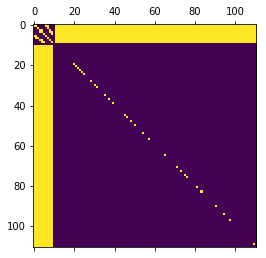

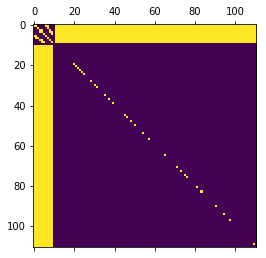

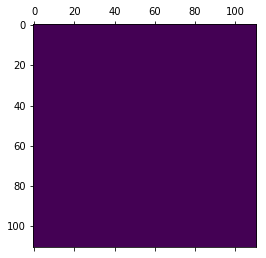

In [83]:
plt.matshow(sparse_hess != 0)
plt.matshow(hess != 0)
plt.matshow(np.abs(sparse_hess - hess) > 1e-6)

print(ll)
print(total_ll)
print(np.max(np.abs(sparse_hess - hess)))

In [ ]:
# Perform EM.

obj.params.set_free(init_par_vec)
obj.optimize_z()
global_param_vec = obj.params['global'].get_vector()
kl = obj.kl()

for step in range(50):
    global_free_par = obj.params['global'].get_free()

    # Different choices for the M step:
    global_vb_opt = optimize.minimize(
       lambda par: obj.global_kl_wrapper(par, verbose=False),
       x0=global_free_par, jac=obj.global_kl_grad, hessp=obj.global_kl_hvp,
       method='trust-ncg', options={'maxiter': 50, 'gtol': 1e-2})
    #global_vb_opt = optimize.minimize(
    #    lambda par: obj.global_kl_wrapper(par, verbose=False),
    #    x0=global_free_par, jac=obj.global_kl_grad, hess=obj.global_kl_hessian,
    #    method='trust-ncg', options={'maxiter': 50})
    #global_vb_opt = optimize.minimize(
    #   lambda par: obj.global_kl_wrapper(par, verbose=False),
    #   x0=global_free_par, method='nelder-mead', options={'maxiter': 500})
    #global_vb_opt = optimize.minimize(
    #   lambda par: obj.global_kl_wrapper(par, verbose=False),
    #  x0=global_free_par, method='bfgs', options={'maxiter': 50})
    obj.params['global'].set_free(global_vb_opt.x)

    # E-step:
    obj.optimize_z()

    new_global_param_vec = obj.params['global'].get_vector()
    diff = np.max(np.abs(new_global_param_vec - global_param_vec))
    global_param_vec = deepcopy(new_global_param_vec)
    
    new_kl = obj.kl()
    kl_diff = new_kl - kl
    kl = new_kl
    print(' kl: {}\t\tkl_diff = {}\t\tdiff = {}'.format(kl, kl_diff, diff))
    if diff < 1e-8:
        break

print('Done.')


In [ ]:
# Finish with one joint Newton optimization to ensure global optimality.
vb_opt = optimize.minimize(
    lambda par: obj.kl_wrapper(par, verbose=True),
    x0=obj.params.get_free(), jac=obj.kl_grad, hessp=obj.kl_hvp,
    method='trust-ncg', options={'maxiter': 50})
obj.params.set_free(vb_opt.x)

In [ ]:
# Check that the solution looks sensible.
mu_fit = obj.params['global']['mu'].get()
plt.plot(x[:,0], x[:,1], 'k.')
for k in range(k_num):
    plt.plot(mu_fit[k, 0], mu_fit[k, 1], 'ro')

In [ ]:
# This is really slow for even problems of moderate size.  You'd want to build this up by hand if
# you actualy needed it.

# hess_time = time.time()
# kl_hessian = obj.kl_hessian(obj.params.get_free())
# hess_time = time.time() - hess_time
# print(hess_time)

In [ ]:
# Get the sensitivity operator with conjugate gradient to avoid constructing the Hessian.

moment_jac = obj.get_moment_jacobian(vb_opt.x)
sensitivity_operator = np.full_like(moment_jac, float('nan'))
free_param_size = len(vb_opt.x)

KLHessVecProdLO = LinearOperator((free_param_size, free_param_size),
                                 lambda vec: obj.kl_hvp(vb_opt.x, vec))
for ind in range(sensitivity_operator.shape[0]):
    cg_res, info = sp.sparse.linalg.cg(KLHessVecProdLO, moment_jac[ind, :].T)
    sensitivity_operator[ind, :] = cg_res

In [ ]:
obj.params.set_free(vb_opt.x)
def kl_weight_fun(weights):
    obj.weights = weights
    return obj.kl()

default_weights = np.full((n_num, 1), 1.0)
get_kl_weight_grad = autograd.grad(kl_weight_fun)
kl_weight_grad = get_kl_weight_grad(default_weights)
mu_weight_sens = np.matmul(sensitivity_operator, kl_weight_grad)